In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split

def get_transform(data_augmentation):
    if data_augmentation:
        transform = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.RandomHorizontalFlip(),
            transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10),
            transforms.ToTensor(),     
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    else:
        # Regular transformations
        transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])
    return transform

def load_dataset(train_folder, test_folder, transform):
    train_dataset = datasets.ImageFolder(train_folder, transform=transform)
    test_dataset = datasets.ImageFolder(test_folder, transform=get_transform(False))
    return train_dataset, test_dataset

def train(model, criterion, optimizer, train_loader, val_loader, test_loader, num_epochs):
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        running_loss = 0.0
        for i, (images, labels) in enumerate(train_loader):
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if (i + 1) % 240 == 0:  # Print every 100 batches
                print(f"Epoch [{epoch + 1}/{num_epochs}], Step [{i + 1}/{len(train_loader)}], Loss: {running_loss / 240:.4f}")
#                 wandb.log({'Epoch': (epoch + 1)/num_epochs, 'Step': (i + 1)/(len(train_loader)), 'Loss': running_loss / 240})
                running_loss = 0.0
        # Validation loop
        model.eval()  # Set the model to evaluation mode
        
        val_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for images, labels in val_loader:
                if torch.cuda.is_available():
                    images, labels = images.cuda(), labels.cuda()

                # Forward pass
                outputs = model(images)
                
                # Calculate loss
                loss = criterion(outputs, labels)
                
                # Update validation loss
                val_loss += loss.item()

                # Calculate accuracy
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        # Calculate average validation loss and accuracy for the epoch
        val_loss /= len(val_loader)
        val_accuracy = correct / total * 100

#         wandb.log({'Val_Loss': val_loss, 'val_accuracy': val_accuracy})
        print(f"Epoch [{epoch + 1}/{num_epochs}], Val Loss: {val_loss:.4f}, Val Acc: {val_accuracy:.2f}%")

    with torch.no_grad():
        for images, labels in test_loader:
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()

            # Forward pass
            outputs = model(images)

            # Calculate loss
            test_loss = criterion(outputs, labels)

            # Update validation loss
            test_loss += test_loss.item()

            # Calculate accuracy
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    # Calculate average validation loss and accuracy for the epoch
    test_loss /= len(test_loader)
    test_accuracy = correct / total * 100

    #         wandb.log({'Val_Loss': val_loss, 'val_accuracy': val_accuracy})
    print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.2f}%")      

class CNN(nn.Module):
    def __init__(self, hparams):
        super(CNN, self).__init__()
        self.hparams = hparams
        num_conv_layers = hparams['num_conv_layers']
        in_channels = 3
        num_filters = hparams['num_filters']
        kernel_size = hparams['kernel_size']  # Single integer value
        num_classes = 10
        num_neurons_dense = hparams['num_neurons_dense']
        input_size = 224
        filter_organization = hparams['filter_organization']
        batch_normalization = hparams['batch_normalization']
        dropout_prob = hparams['dropout_prob']
        conv_activation = hparams['conv_activation']

        self.conv_layers = nn.ModuleList()
        self.num_conv_layers = num_conv_layers

        # Add convolution layers
        for i in range(num_conv_layers):
            # Determine the number of filters for this layer based on filter_organization
            if filter_organization == 'same':
                out_channels = num_filters
            elif filter_organization == 'double':
                out_channels = num_filters * (2 ** i)
            elif filter_organization == 'halve':
                out_channels = num_filters // (2 ** i)
            else:
                raise ValueError("Invalid filter organization")

            # Determine padding value to maintain spatial dimensions
            padding = kernel_size // 2 if kernel_size % 2 == 1 else (kernel_size - 1) // 2

            # Add convolution layer with the same kernel size for all layers
            conv_layer = nn.Conv2d(in_channels, out_channels, kernel_size, padding=padding)
            self.conv_layers.append(conv_layer)

            # Add batch normalization if enabled
            if batch_normalization:
                bn_layer = nn.BatchNorm2d(out_channels)
                self.conv_layers.append(bn_layer)

            in_channels = out_channels

        # Add dropout layer after the last convolution layer
        self.dropout_conv = nn.Dropout2d(p=dropout_prob)

        # Calculate input size for dense layer
        dense_input_size = out_channels * (input_size // (2 ** num_conv_layers)) ** 2

        # Dense layer
        self.dense = nn.Linear(dense_input_size, num_neurons_dense)

        # Output layer
        self.output = nn.Linear(num_neurons_dense, num_classes)

    def forward(self, x):
        # Convolution layers
        for i, layer in enumerate(self.conv_layers):
            x = layer(x)
            if isinstance(layer, nn.Conv2d):
                # Apply activation function dynamically
                if self.hparams['conv_activation'] == 'relu':
                    x = F.relu(x)
                elif self.hparams['conv_activation'] == 'gelu':
                    x = F.gelu(x)
                elif self.hparams['conv_activation'] == 'mish':
                    x = F.mish(x)
                else:
                    raise ValueError("Invalid convolutional activation function")
                
                x = F.max_pool2d(x, 2)

        # Flatten
        x = torch.flatten(x, 1)

        # Dense layer
        x = F.relu(self.dense(x))

        # Output layer (raw scores)
        x = self.output(x)
        return x

def save_model(model, save_path):
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    torch.save(model, save_path)
    print(f"Model saved at {save_path}")

def main(hparams):
        
        train_folder = '/kaggle/input/dataset-cs6910-a2/inaturalist_12K/train'
        test_folder = '/kaggle/input/dataset-cs6910-a2/inaturalist_12K/val'
        transform = get_transform(hparams['data_augmentation'])
        train_dataset, test_dataset = load_dataset(train_folder, test_folder, transform)

        # Define batch size for DataLoader
        batch_size = 32

        # Split train dataset into train and validation sets
        train_indices, val_indices = train_test_split(list(range(len(train_dataset))), test_size=0.2, shuffle=True, stratify=train_dataset.targets)
        train_sampler = torch.utils.data.SubsetRandomSampler(train_indices)
        val_sampler = torch.utils.data.SubsetRandomSampler(val_indices)

        # Create DataLoader for train and validation datasets
        train_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=train_sampler)
        val_loader = DataLoader(train_dataset, batch_size=batch_size, sampler=val_sampler)
        test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

        # Print the number of samples in train and validation sets after splitting
        print("Number of samples in train set after splitting:", len(train_indices))
        print("Number of samples in validation set after splitting:", len(val_indices))

        for images, labels in train_loader:
            # Get the shape of the image tensor (batch_size, channels, height, width)
            batch_size, in_channels, height, width = images.shape
            # Get the number of unique classes in the dataset
            num_classes = len(train_dataset.classes)
            # Input size is the height and width of the image
            input_size = height, width
            break  # Break after processing the first batch

        print("In channels:", in_channels)
        print("Number of classes:", num_classes)
        print("Input size (height, width):", input_size)


        # Create the model
        model = CNN(hparams)
        # Define loss function and optimizer
        criterion = nn.CrossEntropyLoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
        # checking if GPU is available
        if torch.cuda.is_available():
            model = model.cuda()
            criterion = criterion.cuda()
        train(model,criterion,optimizer,train_loader,val_loader, test_loader, hparams['max_epoch'])
        
        # Save the trained model
        save_model(model, "/kaggle/working/trained_model.pth")
        
        
hparams = {
    'num_conv_layers': 5,
#     'in_channels': 0,
    'num_filters': 128,
    'kernel_size': 3,
#     'num_classes': 0,
    'num_neurons_dense': 100,
#     'input_size': 0,
    'filter_organization': 'halve',
    'data_augmentation': False,  
    'batch_normalization': False,  # Set to True or False as needed
    'dropout_prob': 0.3,
    'conv_activation': 'mish',
    'max_epoch': 10
}

main(hparams)    

Number of samples in train set after splitting: 7999
Number of samples in validation set after splitting: 2000
In channels: 3
Number of classes: 10
Input size (height, width): (224, 224)
Epoch [1/10], Step [240/250], Loss: 2.2268
Epoch [1/10], Val Loss: 2.1016, Val Acc: 24.70%
Epoch [2/10], Step [240/250], Loss: 2.0852
Epoch [2/10], Val Loss: 2.0014, Val Acc: 28.95%
Epoch [3/10], Step [240/250], Loss: 2.0217
Epoch [3/10], Val Loss: 2.0227, Val Acc: 27.10%
Epoch [4/10], Step [240/250], Loss: 1.9887
Epoch [4/10], Val Loss: 1.9220, Val Acc: 31.50%
Epoch [5/10], Step [240/250], Loss: 1.9502
Epoch [5/10], Val Loss: 1.9444, Val Acc: 29.95%
Epoch [6/10], Step [240/250], Loss: 1.9241
Epoch [6/10], Val Loss: 1.9175, Val Acc: 32.60%
Epoch [7/10], Step [240/250], Loss: 1.8929
Epoch [7/10], Val Loss: 1.8952, Val Acc: 34.25%
Epoch [8/10], Step [240/250], Loss: 1.8547
Epoch [8/10], Val Loss: 1.9206, Val Acc: 32.75%
Epoch [9/10], Step [240/250], Loss: 1.8251
Epoch [9/10], Val Loss: 1.8736, Val Acc: 3

# Visualise

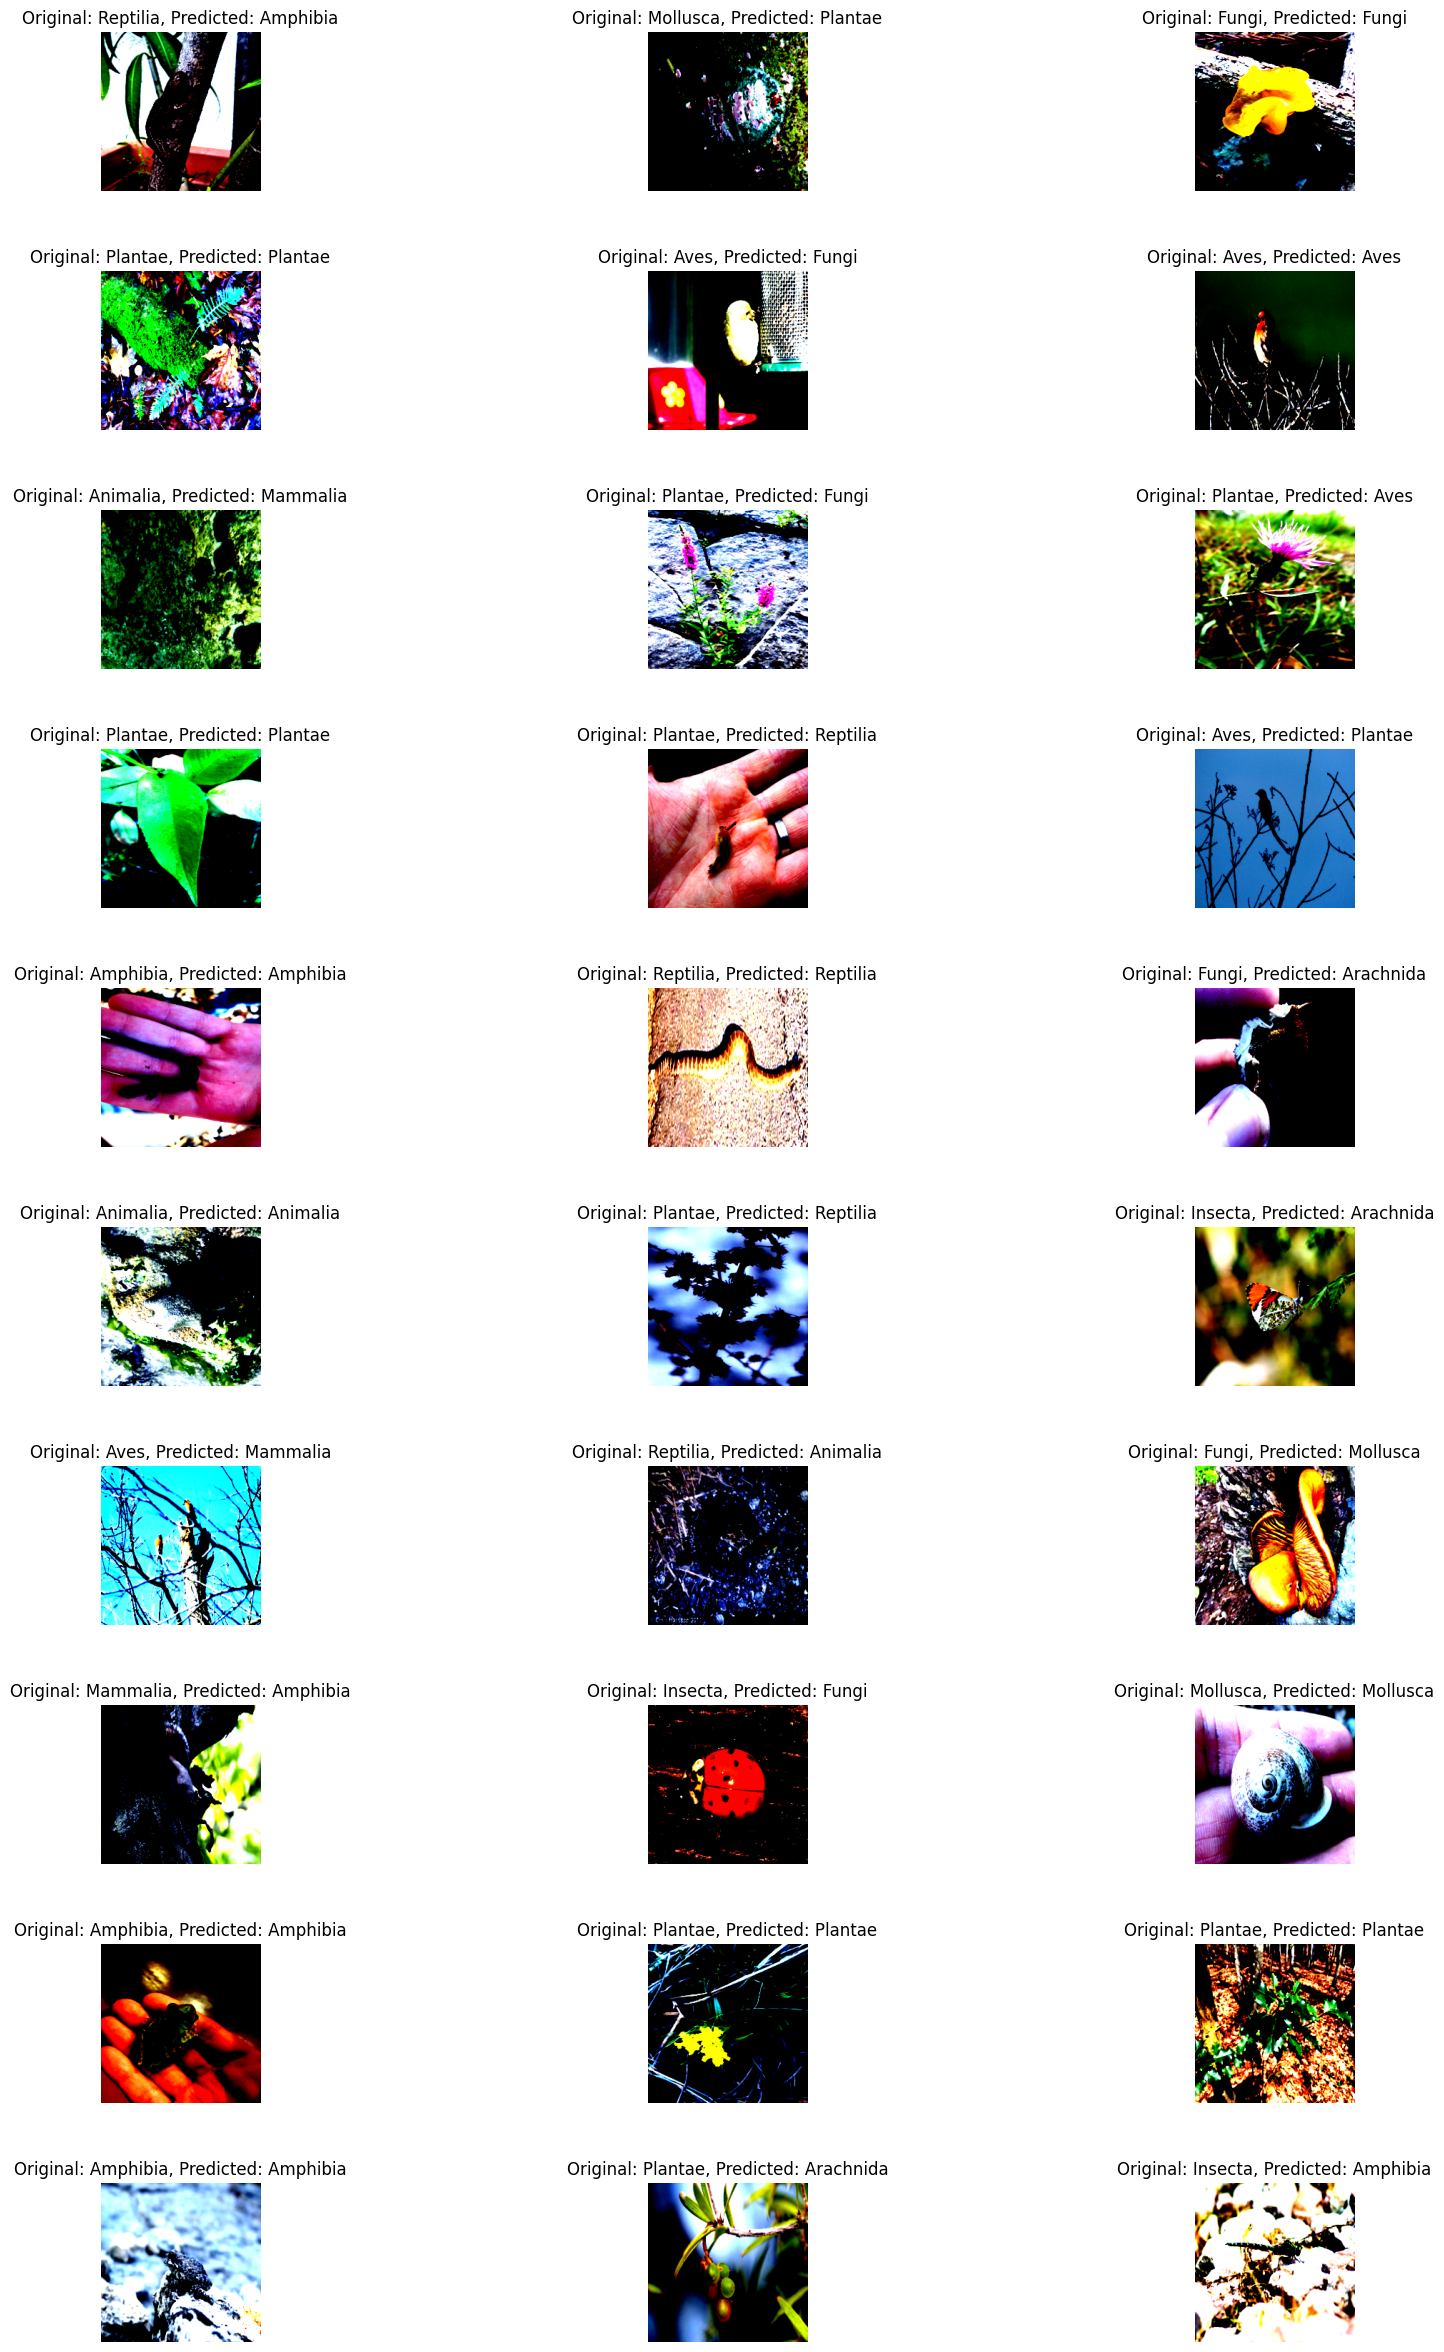

In [10]:
import torch
import torchvision.transforms as transforms
from torchvision import datasets
import matplotlib.pyplot as plt
import numpy as np

# Define the device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the transform to be applied to each image
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to fit the model input
    transforms.ToTensor(),  # Convert PIL image to tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize image data
])

# Load the test dataset
test_dataset = datasets.ImageFolder('/kaggle/input/dataset-cs6910-a2/inaturalist_12K/val', transform=transform)

# Load the trained model
model = torch.load('/kaggle/working/trained_model.pth', map_location=device)
model.eval()  # Set the model to evaluation mode

save_path = '/kaggle/working/'
# Define a function to display a grid of images along with their predicted labels
def display_images_with_predictions(images, predictions, original_labels, classes, save_path=None):
    fig, axes = plt.subplots(10, 3, figsize=(20, 30))
    fig.subplots_adjust(hspace=0.5)
    for i, ax in enumerate(axes.flat):
        image, prediction, original_label = images[i], predictions[i], original_labels[i]
        image = image.permute(1, 2, 0)  # Reshape image tensor for display
        ax.imshow(image)
        ax.axis('off')
        ax.set_title(f'Original: {classes[original_label]}, Predicted: {classes[prediction]}')
    
    # Save the figure as PNG if save_path is provided
    if save_path:
        plt.savefig(save_path, bbox_inches='tight')

# Randomly select a subset of images from the test dataset
subset_indices = np.random.choice(len(test_dataset), size=30, replace=False)
subset_loader = torch.utils.data.DataLoader(test_dataset, batch_size=30, sampler=torch.utils.data.SubsetRandomSampler(subset_indices))

# Iterate through the subset and make predictions
images = []
predictions = []
original_labels = []
with torch.no_grad():
    for batch_images, batch_labels in subset_loader:
        batch_images = batch_images.to(device)
        batch_predictions = model(batch_images)
        _, batch_predicted_labels = torch.max(batch_predictions, 1)
        images.extend(batch_images.cpu())
        predictions.extend(batch_predicted_labels.cpu().numpy())
        original_labels.extend(batch_labels.numpy())

# Display the grid of images along with their predicted labels
classes = test_dataset.classes
display_images_with_predictions(images, predictions, original_labels, classes, save_path='grid_predictions.png')

plt.show()
